In [1]:
# Import GW packages
import numpy as np
from lal import GreenwichMeanSiderealTime
from ripple import ms_to_Mc_eta
from ripple.waveforms.IMRPhenomD import gen_IMRPhenomD_polar
from jaxgw.PE.detector_preset import *
from jaxgw.PE.single_event_likelihood import single_detector_likelihood
from jaxgw.PE.detector_projection import make_detector_response, get_detector_response
from jaxgw.PE.generate_noise import generate_noise
import matplotlib.pyplot as plt

# Import FlowMC stuff
from flowMC.sampler.HMC import HMC
from flowMC.sampler.Gaussian_random_walk import GaussianRandomWalk
from flowMC.nfmodel.rqSpline import RQSpline
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
import jax
import jax.numpy as jnp

# Plotting
import corner
import matplotlib.pyplot as plt

In [94]:
#########################################
# Setting up the GW likleilhood
#########################################

# Detector Setup

f_sampling: 2048
duration: 8
fmin: 20

f_sampling = 1024
duration = 16
fmin = 20
ifos = ["H1", "L1", "V1"]

freqs, psd_dict, noise_dict = generate_noise(1234, f_sampling, duration, fmin, ifos)


H1 = get_H1()
L1 = get_L1()
V1 = get_V1()

f_ref = fmin
trigger_time = 1126259462.4
post_trigger_duration = 4
epoch = duration - post_trigger_duration
gmst = GreenwichMeanSiderealTime(trigger_time)

# True parameters for injection

# Mc, eta, chi1, chi2, dist, tc, phic, inclination, polarization_angle, ra, dec,
m1 = 60
m2 = 30
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
true_params = jnp.array(
    [Mc, eta, 0.3, -0.4, 800, 0.0, 0.0, np.pi / 3, np.pi / 3, np.pi / 3, np.pi / 3]
)
true_param_intrinsic = jnp.array([Mc, eta, 0.3, -0.4])

# We now can generate data

f_list = freqs[freqs > fmin]
psd_list = [psd_dict["H1"][freqs > fmin], psd_dict["L1"][freqs > fmin]]
waveform_generator = lambda f_, theta_: gen_IMRPhenomD_polar(f_, theta_, f_ref)

H1_signal = get_detector_response(
    waveform_generator, true_params, f_list, H1, gmst, epoch
)
H1_noise_psd = noise_dict["H1"][freqs > fmin]
H1_data = H1_noise_psd + H1_signal

L1_signal = get_detector_response(
    waveform_generator, true_params, f_list, L1, gmst, epoch
)
L1_noise_psd = noise_dict["L1"][freqs > fmin]
L1_data = L1_noise_psd + L1_signal


def logL(p):
    # Adding on the true ones
    extrinsic_variables = jnp.array(
        [1500, 0.0, 0.0, np.pi / 3, np.pi / 3, np.pi / 3, np.pi / 3]
    )
    params = jnp.concatenate((p, extrinsic_variables))
    logL_H1 = single_detector_likelihood(
        waveform_generator, params, H1_data, f_list, psd_list[0], H1, gmst, epoch
    )
    logL_L1 = single_detector_likelihood(
        waveform_generator, params, L1_data, f_list, psd_list[1], L1, gmst, epoch
    )

    return logL_H1 + logL_L1


In [96]:
n_dim = 4
n_chains = 30
n_local_steps = 500
step_size = 0.1
n_leapfrog = 10

# RWMCMC = GaussianRandomWalk(logL, True, {"step_size": step_size})

mass_matrix = np.ones(n_dim)
# mass_matrix = np.abs(1./(jax.grad(logL)(true_param_intrinsic)+jax.grad(top_hat)(true_param_intrinsic)))*mass_matrix
mass_matrix = np.abs(1./(jax.grad(logL)(true_param_intrinsic)))*mass_matrix
mass_matrix = jnp.array(mass_matrix)
print(mass_matrix)
# HMC = HMC(like, True, {"step_size": step_size*mass_matrix,...

HMC_init = HMC(
    logL,
    True,
    {
        "step_size": step_size*mass_matrix,
        "n_leapfrog": n_leapfrog,
        "inverse_metric": jnp.ones(n_dim),
    },
)

rng_key_set = initialize_rng_keys(n_chains, seed=41)

initial_noise = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim)) * 1
initial_mean = jnp.array([Mc, eta, 0.3, -0.4]).reshape(1,4)
sigma = jnp.array([0.1, 0.001, 0.1, 0.1]).reshape(1,4)

initial_position = initial_mean + sigma * initial_noise

[1.94449596e-02 6.75452018e-04 1.84577437e-03 1.47149484e+00]


In [97]:
initial_Ham = jax.vmap(HMC_init.get_initial_hamiltonian, in_axes=(0, 0, None))(
    rng_key_set[1], initial_position, HMC_init.params
)

HMC_kernel = HMC_init.make_kernel()

print(HMC_kernel(rng_key_set[0], initial_position[0], initial_Ham[0], HMC_init.params))


HMC_update = HMC_init.make_update()
HMC_update = jax.vmap(
    HMC_update, in_axes=(None, (0, 0, 0, 0, None)), out_axes=(0, 0, 0, 0, None)
)

initial_position = jnp.repeat(initial_position[:, None], n_local_steps, 1)
initial_Ham = jnp.repeat(initial_Ham[:, None], n_local_steps, 1)

state = (
    rng_key_set[1],
    initial_position,
    initial_Ham,
    jnp.zeros((n_chains, n_local_steps, 1)),
    HMC_init.params,
)


HMC_update(1, state)

HMC_sampler = HMC_init.make_sampler()

state = HMC_sampler(rng_key_set[1], n_local_steps, initial_position[:, 0])

(DeviceArray([36.51077732,  0.22203034,  0.40714808, -0.4348359 ], dtype=float64), DeviceArray(-387.45447388, dtype=float64), DeviceArray(False, dtype=bool))


Sampling Locally:   0%|                                                                                                                                                                       | 0/499 [00:21<?, ?it/s]2022-12-02 19:20:24.382118: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_hmc_update] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-12-03 03:40:22.766743: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10h41m26.926386s

********************************
[Compiling module jit_hmc_update] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Sampling Locally: 100%|████████████████████████████████████████████████████████

In [98]:
chains = state[1].reshape(-1, n_dim)

In [99]:
print(chains.shape)

(15000, 4)


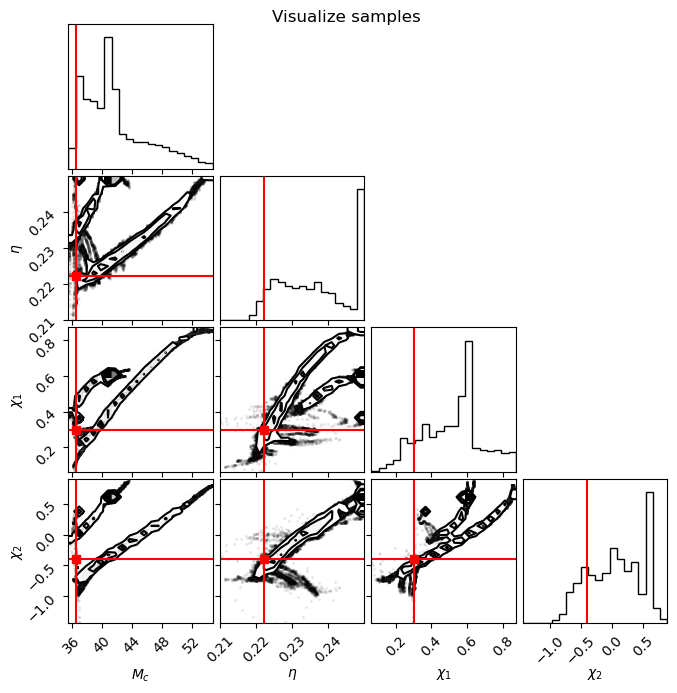

In [100]:
chains = np.array(accepted_points)
labels=["$M_c$", "$\eta$", "$\chi_1$", "$\chi_2$"]
# Plot all chains
figure = corner.corner(
    chains, labels=labels
)

# Extract the axes
axes = np.array(figure.axes).reshape((n_dim, n_dim))

# Loop over the diagonal
for i in range(n_dim):
    ax = axes[i, i]
    ax.axvline(true_param_intrinsic[i], color="r")

# Loop over the histograms
for yi in range(n_dim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true_param_intrinsic[xi], color="r")
        ax.axhline(true_param_intrinsic[yi], color="r")
        ax.plot(true_param_intrinsic[xi], true_param_intrinsic[yi], "sr")

figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

In [22]:
# print("Initializing sampler class")

# nf_sampler_MCMC = Sampler(
#     n_dim,
#     rng_key_set,
#     RWMCMC,
#     logL,
#     model,
# #     n_loop_training=n_loop_training,
# #     n_loop_production=n_loop_production,
# #     n_local_steps=n_local_steps,
# #     n_global_steps=n_global_steps,
#     n_chains=n_chains,
#     use_global=False,
# )

# nf_sampler_MCMC.sample(initial_position)

Initializing sampler class
No autotune found, use input sampler_params
Starting Production run


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 86.37it/s]


In [23]:
# out_train = nf_sampler_MCMC.get_sampler_state()
# chains = np.array(out_train['chains'])
# global_accs = np.array(out_train['global_accs'])
# local_accs = np.array(out_train['local_accs'])
# print(chains.reshape(-1, n_dim))

[[ 48.28413036   0.24674311   0.31371644  -0.32236438]
 [ 48.28413036   0.24674311   0.31371644  -0.32236438]
 [ 48.28413036   0.24674311   0.31371644  -0.32236438]
 ...
 [ 53.96837384   0.16717932 -35.98047049  19.28364431]
 [ 53.96837384   0.16717932 -35.98047049  19.28364431]
 [ 53.96837384   0.16717932 -35.98047049  19.28364431]]


In [44]:
print("Initializing sampler class")

nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    HMC_init,
    logL,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    use_global=False,
)

nf_sampler.sample(initial_position)

Initializing sampler class
No autotune found, use input sampler_params
Starting Production run


Sampling Locally:   0%|                                                                                                                                                                        | 0/99 [00:13<?, ?it/s]2022-12-01 14:11:39.055658: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 9m2.240568s

********************************
[Compiling module jit_hmc_update] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Sampling Locally: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:44<00:00,  2.23it/s]


In [55]:
# out_train = nf_sampler.get_sampler_state()
# print('Logged during tuning:', out_train.keys())

# chains = np.array(out_train['chains'])
# global_accs = np.array(out_train['global_accs'])
# local_accs = np.array(out_train['local_accs'])

Logged during tuning: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs'])


In [56]:
chains
# chains.reshape(-1, n_dim)

array([[[43.42379052,  0.24846088,  0.3100499 , -0.38474316],
        [43.42379052,  0.24846088,  0.3100499 , -0.38474316],
        [43.42379052,  0.24846088,  0.3100499 , -0.38474316],
        ...,
        [43.42379052,  0.24846088,  0.3100499 , -0.38474316],
        [43.42379052,  0.24846088,  0.3100499 , -0.38474316],
        [43.42379052,  0.24846088,  0.3100499 , -0.38474316]],

       [[49.85433783,  0.24747479,  0.32421459, -0.4025905 ],
        [49.85433783,  0.24747479,  0.32421459, -0.4025905 ],
        [49.85433783,  0.24747479,  0.32421459, -0.4025905 ],
        ...,
        [49.85433783,  0.24747479,  0.32421459, -0.4025905 ],
        [49.85433783,  0.24747479,  0.32421459, -0.4025905 ],
        [49.85433783,  0.24747479,  0.32421459, -0.4025905 ]],

       [[48.53383726,  0.24786374,  0.30872138, -0.39106961],
        [48.53383726,  0.24786374,  0.30872138, -0.39106961],
        [48.53383726,  0.24786374,  0.30872138, -0.39106961],
        ...,
        [48.53383726,  0.24

NameError: name 'loss_vals' is not defined

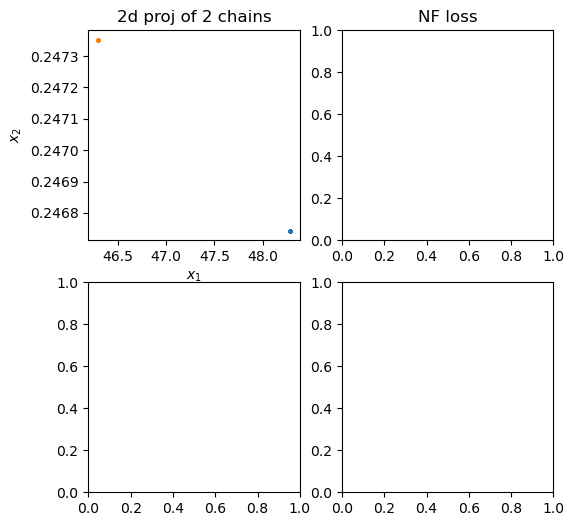

In [20]:
chains = np.array(out_train['chains'])
global_accs = np.array(out_train['global_accs'])
local_accs = np.array(out_train['local_accs'])
# loss_vals = np.array(out_train['loss_vals'])
# print(chains, global_accs, local_accs, loss_vals)
# nf_samples = np.array(nf_sampler.sample_flow(1000)[1])


# Plot 2 chains in the plane of 2 coordinates for first visual check 
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], 'o-', alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], 'o-', alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=labels
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
# figure = corner.corner(nf_samples, labels=labels)
# figure.set_size_inches(7, 7)
# figure.suptitle("Visualize NF samples")
# plt.show()